In [263]:
#### Agglomeration of communities ####

import pandas as pd 
import os 
from datetime import datetime 
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np

In [183]:
cwd = os.getcwd()
input_path = f"{cwd}/Data/frequencies/"
output_path = f"{cwd}/Data/celldata/"

date = datetime.now().strftime("%Y%m%d")
cutoff = 25

groups = ['MOC2_CCR2KO', 'MOC2_WT']
WT = pd.read_csv(f"{input_path}freqs_{groups[1]}_{cutoff}px_20240415.csv")
KO = pd.read_csv(f"{input_path}freqs_{groups[0]}_{cutoff}px_20240415.csv")
WT['Group'] = 'WT'
KO['Group'] = 'CCR2KO'

MOC2 = pd.concat([WT,KO])
MOC2

,Unique_ROI_ID,source_ID,source_cluster,Dendritic cells,Endothelium Thy1+,Endothelium Thy1-,Fibroblasts,Macrophages CD68,Macrophages F480,Neutrophils,T cell CD4,T cell CD8,T cell regulatory,Tumour,Undefined,cDC1 Dendritic cells,Group
0,MOC2_WT_1B_2_17,1,Endothelium Thy1+,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.500000,0.0,0.000000,WT
1,MOC2_WT_1B_2_17,2,Tumour,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.750000,0.0,0.000000,WT
2,MOC2_WT_1B_2_17,3,Tumour,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.833333,0.0,0.000000,WT
3,MOC2_WT_1B_2_17,4,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,WT
4,MOC2_WT_1B_2_17,5,Endothelium Thy1+,0.142857,0.000000,0.0,0.0,0.142857,0.0,0.00,0.0,0.0,0.0,0.428571,0.0,0.285714,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348806,MOC2_CCR2KO_NM_1_16,80728,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,CCR2KO
348807,MOC2_CCR2KO_NM_1_16,80729,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,CCR2KO
348808,MOC2_CCR2KO_NM_1_16,80730,Macrophages CD68,0.000000,0.000000,0.0,0.0,0.111111,0.0,0.00,0.0,0.0,0.0,0.888889,0.0,0.000000,CCR2KO
348809,MOC2_CCR2KO_NM_1_16,80731,Tumour,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.00,0.0,0.0,0.0,0.500000,0.0,0.000000,CCR2KO


In [258]:
# match cell type names in colummns and rows

# Rows
replacement_map = {'Endothelium Thy1+':'Endothelium_thy1_high',
       'T cell CD4':'Tcell_CD4',
       'T cell CD8':'Tcell_CD8', 'Macrophages CD68':'Macrophage_CD68', 'Dendritic cells':'DCs',
       'cDC1 Dendritic cells':'cDC1_DCs', 'T cell regulatory':'Treg', 'Macrophages F480':'Macrophage_F480',
       'Endothelium Thy1-':'Endothelium_thy1_low'}
MOC2['source_cluster'] = MOC2['source_cluster'].replace(replacement_map)
MOC2['source_cluster'].unique()

# Columns
MOC2 = MOC2.rename(columns=replacement_map)
MOC2.columns

df = MOC2.iloc[:,3:-1]
MOC2.columns

MOC2.to_csv(f"{output_path}MOC2_KO_WT_merged_cd.csv", index = False)


In [16]:
# PERFORM CLUSTERING BEFORE CONTINUING
# ---------------------------------------------


In [261]:
# Set celltype color combo and assert number of celltypes
colors = ['#e6194B', '#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', '#fabed4', '#9A6324', '#aaffc3', '#000075', '#a9a9a9', '#000000']
cts = ['Macrophage_F480', 'Tumour', 'Macrophage_CD68', 'Fibroblasts', 'DCs',  'Endothelium_thy1_high', 'Endothelium_thy1_low', 'Neutrophils', 'cDC1_DCs', 'Tcell_CD8', 'Tcell_CD4', 'Treg', 'Undefined']
len(cts)

13

In [52]:
# Load clusters

# Find datafile
file = 'Rphenograph_CRICK_MOC2_output_306clusters_k250_13ct_fractions.csv' 
# pi = pd.read_excel('Data/raw/LUAD Clinical Data.xlsx')

# Get current directory
current_directory = os.getcwd()
data_path = current_directory + '/Data/'

# Set path 
output_dir = f"{data_path}/clustering/agglomerate_communities_python/"


data = pd.read_csv(f"{data_path}clustering/{file}", index_col=0)
data

,Unique_ROI_ID,source_ID,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,Group,cluster
1,MOC2_WT_1B_2_17,1,Endothelium_thy1_high,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.500000,0.0,0.000000,WT,1
2,MOC2_WT_1B_2_17,2,Tumour,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.750000,0.0,0.000000,WT,2
3,MOC2_WT_1B_2_17,3,Tumour,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.833333,0.0,0.000000,WT,3
4,MOC2_WT_1B_2_17,4,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,WT,4
5,MOC2_WT_1B_2_17,5,Endothelium_thy1_high,0.142857,0.000000,0.0,0.0,0.142857,0.0,0.00,0.0,0.0,0.0,0.428571,0.0,0.285714,WT,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704345,MOC2_CCR2KO_NM_1_16,80728,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,CCR2KO,4
704346,MOC2_CCR2KO_NM_1_16,80729,Tumour,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,CCR2KO,4
704347,MOC2_CCR2KO_NM_1_16,80730,Macrophage_CD68,0.000000,0.000000,0.0,0.0,0.111111,0.0,0.00,0.0,0.0,0.0,0.888889,0.0,0.000000,CCR2KO,7
704348,MOC2_CCR2KO_NM_1_16,80731,Tumour,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.00,0.0,0.0,0.0,0.500000,0.0,0.000000,CCR2KO,15


In [53]:

data = data[['Unique_ROI_ID', 'source_ID', 'Group', 'source_cluster', 'DCs',
       'Endothelium_thy1_high', 'Endothelium_thy1_low', 'Fibroblasts',
       'Macrophage_CD68', 'Macrophage_F480', 'Neutrophils', 'Tcell_CD4',
       'Tcell_CD8', 'Treg', 'Tumour', 'Undefined', 'cDC1_DCs', 
       'cluster']]
df = data.iloc[:,4:]
df

,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,cluster
1,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.500000,0.0,0.000000,1
2,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.750000,0.0,0.000000,2
3,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.833333,0.0,0.000000,3
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,4
5,0.142857,0.000000,0.0,0.0,0.142857,0.0,0.00,0.0,0.0,0.0,0.428571,0.0,0.285714,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704345,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,4
704346,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,1.000000,0.0,0.000000,4
704347,0.000000,0.000000,0.0,0.0,0.111111,0.0,0.00,0.0,0.0,0.0,0.888889,0.0,0.000000,7
704348,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.00,0.0,0.0,0.0,0.500000,0.0,0.000000,15


In [255]:
#### Agglomerative clustering function ####

def agglomerative_clustering(k, average_neighbours, avg_noCluster, agglomerate_to):
    
    # Agglomerative clustering to chosen number of communities as determined by own biological knowledge of the data
    ac1 = AgglomerativeClustering(linkage = 'average', n_clusters = agglomerate_to)
    agglomerate1 = pd.DataFrame(ac1.fit_predict(avg_noCluster))
    # Rename column
    agglomerate1.columns = [f"clusterstotal_{agglomerate_to}"]
    agglomerate1[f"clusterstotal_{agglomerate_to}"] += 1
    # Add agglomerated data to average neighbours 
    average_neighbours = average_neighbours.join(agglomerate1)    
    # Save data with added columns 
    average_neighbours.to_csv(f"{data_path}clustering/reclustered_{agglomerate_to}.csv", index = False)
    print('dataset saved')

    return pd.DataFrame(average_neighbours)

In [262]:
# Create average_neighbours/centroids
centroid_noclus = df.groupby('cluster').mean()
centroids = centroid_noclus.reset_index()
# Assert shape
print(centroid_noclus.shape)
centroid_noclus


KeyError: 'cluster'

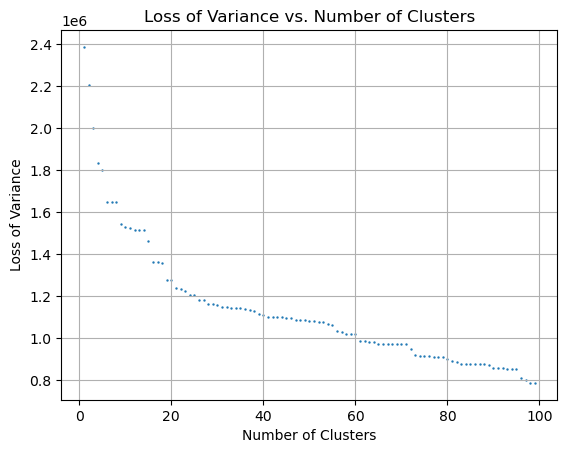

In [58]:
# Function to calculate the loss of variance
def calculate_loss_of_variance(clusters, data):
    loss = 0
    for cluster_id in np.unique(clusters):
        cluster_data = data.loc[clusters == cluster_id, data.columns != 'Cluster']
        centroid = cluster_data.mean(axis=0)
        cluster_loss = np.sum(pairwise_distances(cluster_data, [centroid])**2)
        loss += cluster_loss
    return loss

# Perform agglomerative clustering
n_clusters_range = range(1, 100)  # Define a range of cluster numbers to try
losses = []
num_clusters_left = []

for n_clusters in n_clusters_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = clustering.fit_predict(centroids.iloc[:,1:])
    loss = calculate_loss_of_variance(clusters, centroids)
    losses.append(loss)
    num_clusters_left.append(n_clusters)

# Plotting loss of variance after every merge
plt.scatter(num_clusters_left, losses, marker='o', s=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Loss of Variance')
plt.title('Loss of Variance vs. Number of Clusters')
plt.grid(True)
plt.savefig(f'{data_path}plots/Loss_var__clusno_MOC2.png', bbox_inches='tight', dpi=300)

plt.show()
# drops in variance occur at merging to 28 41 56



In [70]:
# Agglomerate to 28 communities 
average_neighbours28= agglomerative_clustering(range(2,centroids.cluster.max()), centroids, centroid_noclus, 28)
# # Agglomerate to 41 communities 
average_neighbours41 = agglomerative_clustering(range(2,centroids.cluster.max()), centroids, centroid_noclus, 41)
# Agglomerate to 56 communities 
average_neighbours56 = agglomerative_clustering(range(2,centroids.cluster.max()), centroids, centroid_noclus, 56)

average_neighbours56

['cluster', 'DCs', 'Endothelium_thy1_high', 'Endothelium_thy1_low', 'Fibroblasts', 'Macrophage_CD68', 'Macrophage_F480', 'Neutrophils', 'Tcell_CD4', 'Tcell_CD8', 'Treg', 'Tumour', 'Undefined', 'cDC1_DCs', 'clusterstotal_28']
dataset saved
['cluster', 'DCs', 'Endothelium_thy1_high', 'Endothelium_thy1_low', 'Fibroblasts', 'Macrophage_CD68', 'Macrophage_F480', 'Neutrophils', 'Tcell_CD4', 'Tcell_CD8', 'Treg', 'Tumour', 'Undefined', 'cDC1_DCs', 'clusterstotal_41']
dataset saved
['cluster', 'DCs', 'Endothelium_thy1_high', 'Endothelium_thy1_low', 'Fibroblasts', 'Macrophage_CD68', 'Macrophage_F480', 'Neutrophils', 'Tcell_CD4', 'Tcell_CD8', 'Treg', 'Tumour', 'Undefined', 'cDC1_DCs', 'clusterstotal_56']
dataset saved


,cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,clusterstotal_56
0,1,0.001312,0.231092,0.002773,0.004952,0.011403,0.000914,0.302614,0.001531,0.003654,0.000303,0.437617,0.001064,0.000771,32
1,2,0.002111,0.028691,0.053416,0.008023,0.105740,0.013300,0.026629,0.001593,0.003388,0.000467,0.755258,0.000770,0.000615,42
2,3,0.012180,0.044625,0.000933,0.002473,0.010735,0.001026,0.026084,0.004768,0.014453,0.002026,0.747974,0.000443,0.132281,30
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5
4,5,0.002739,0.006579,0.000826,0.013889,0.138261,0.001289,0.002288,0.002675,0.002171,0.000774,0.742517,0.000428,0.085563,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,302,0.000000,0.000000,0.000000,0.000000,0.268951,0.000000,0.000000,0.000000,0.000000,0.000606,0.730443,0.000000,0.000000,2
302,303,0.000000,0.000000,0.000000,0.000000,0.033592,0.000000,0.000000,0.000000,0.000000,0.000000,0.966408,0.000000,0.000000,5
303,304,0.000000,0.000000,0.000568,0.000000,0.476924,0.000728,0.000000,0.000295,0.000000,0.000813,0.518203,0.000709,0.001759,20
304,305,0.000000,0.000000,0.000000,0.036598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.963402,0.000000,0.000000,5


In [242]:
# Annotate entire dataset with clusters after specific clustering k
df_cl = average_neighbours56
num_clus = df_cl.iloc[:,-1].max()
key = df_cl[['cluster', f'clusterstotal_{num_clus}']]
merged_df = pd.merge(data, key, on='cluster', how='inner').drop(columns=['cluster', 'source_ID', 'Unique_ROI_ID', 'Group'])
merged_df_bu = pd.merge(data, key, on='cluster', how='inner')

merged_df_bu.rename(columns={f'cluster{num_clus}': f'clusterstotal_{num_clus}'}, inplace=True)
merged_df_bu.rename(columns={f'cluster': f'clusterstotal_306'}, inplace=True)

merged_df

,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,clusterstotal_56
0,Endothelium_thy1_high,0.0,0.250000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0,32
1,Neutrophils,0.0,0.285714,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.571429,0.0,0.0,32
2,Endothelium_thy1_high,0.0,0.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.666667,0.0,0.0,32
3,Tumour,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.666667,0.0,0.0,32
4,Tumour,0.0,0.200000,0.0,0.1,0.0,0.0,0.100000,0.0,0.0,0.0,0.600000,0.0,0.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704344,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,8
704345,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,8
704346,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,8
704347,Macrophage_CD68,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,8


<Figure size 2000x1000 with 0 Axes>

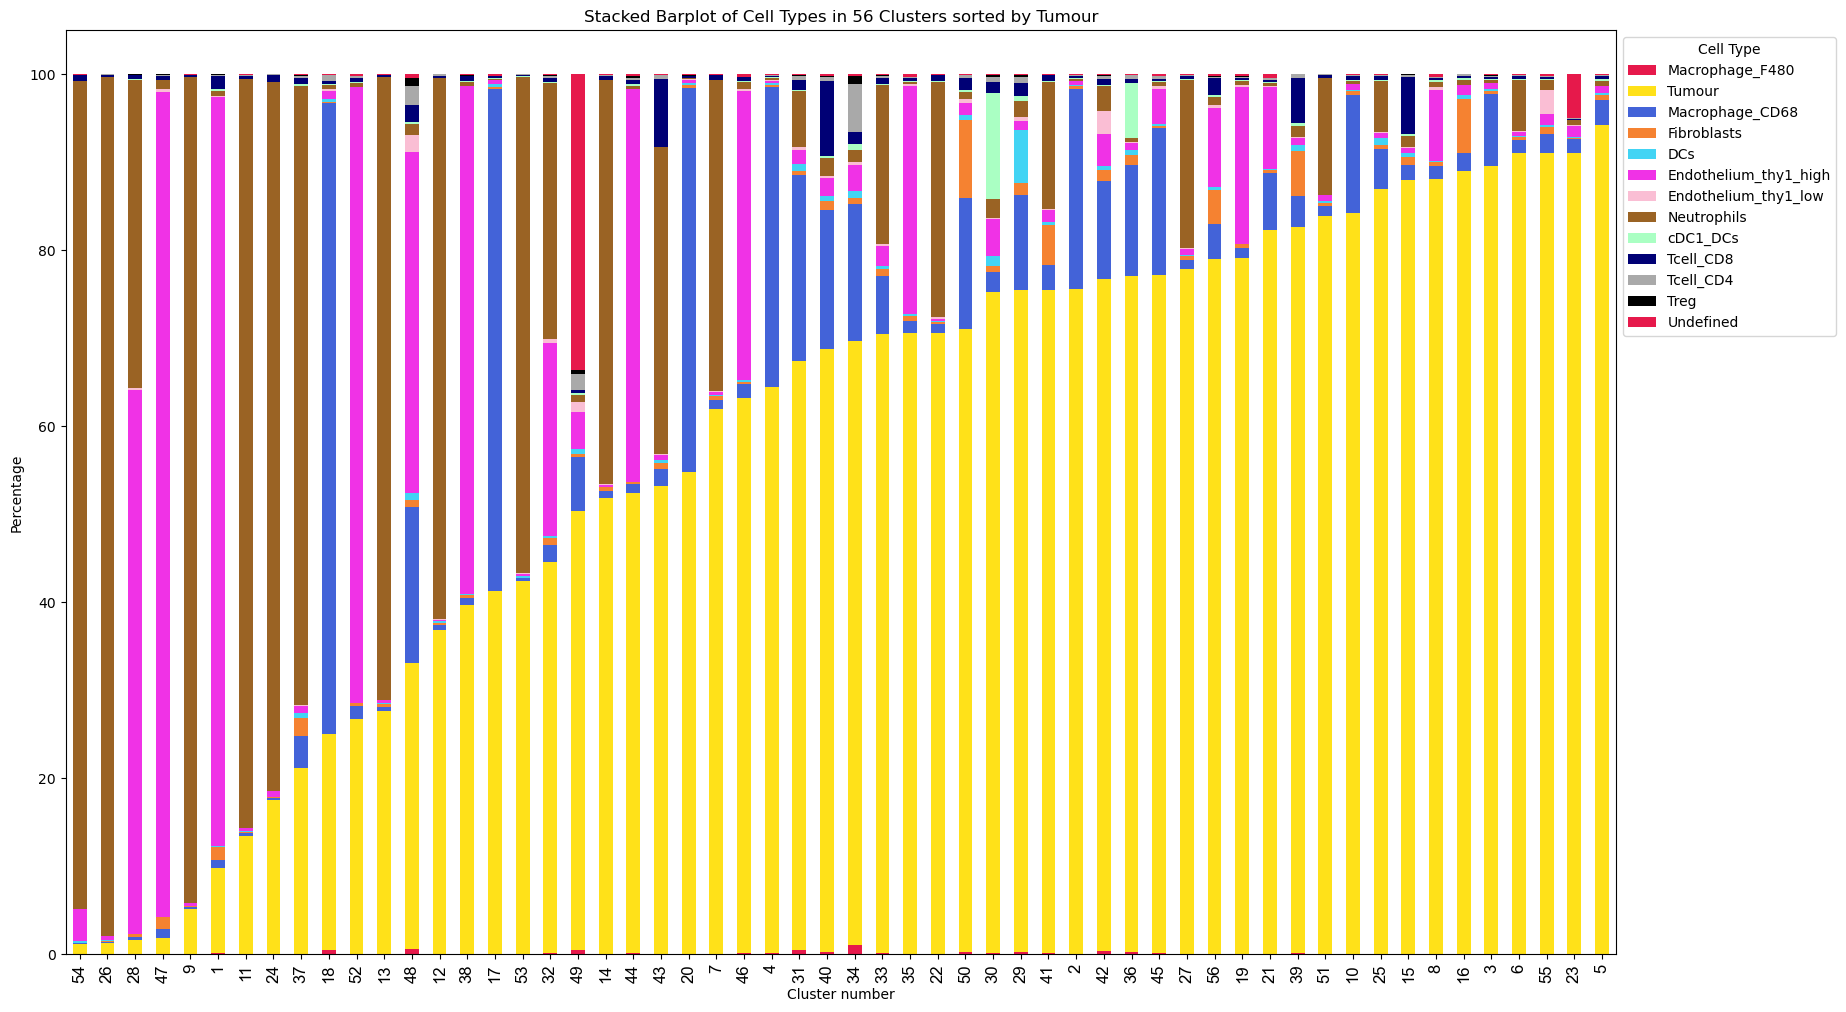

In [243]:
sort_celltype = 'Tumour'

# Grouping by 'cluster' and 'celltype' and getting counts
result = merged_df.groupby([f'clusterstotal_{num_clus}', 'source_cluster']).size().reset_index(name='Count')

# Pivot the table to get totals per cluster and cell type
result = result.pivot_table(index='source_cluster', columns=f'clusterstotal_{num_clus}', values='Count', fill_value=0)
# Sort by dendrogram
# result = result[clus_order]

# Add totals for each cell type and each cluster
# result['Total_Cell_Type'] = result.sum(axis=1)
result.loc['Total_Cells'] = result.sum()

result_percentage = result.div(result.loc['Total_Cells'], axis=1) * 100

# Sort the columns based on the values in the selected row
sorted_columns = result_percentage.columns[result_percentage.loc[sort_celltype].argsort()]

# Reorder the DataFrame based on the sorted columns
result_percentage = result_percentage.iloc[:-1][sorted_columns]

# Reorder rows based on index
result_percentage = result_percentage.reindex(cts)


# Plotting
plt.figure(figsize=(20, 10))

ax = result_percentage.T.plot(kind='bar', stacked=True, figsize=(20, 12),width=0.5, color=colors)
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster number')
ax.set_title(f'Stacked Barplot of Cell Types in {num_clus} Clusters sorted by {sort_celltype}')
# plt.xticks(fontsize=3)
plt.xticks(fontsize=12, fontfamily='Arial', fontweight='normal')

# # Annotate total amount of cells above each bar
# for i, total in enumerate(result.loc['Total_Cells'][:-1]):  # Exclude the 'Total_Cells' row
#     ax.annotate(f'{total}', (i, 100), xytext=(0, 5), textcoords='offset points', ha='center', rotation=90, fontsize=3)

# Show plot
plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))

# plt.savefig(f'{data_path}plots/stacked_barplot_clusno_{num_clus}_sorted_{sort_celltype}.png', bbox_inches='tight', dpi=300)

plt.show()

In [246]:
# Annotate entire dataset with clusters after specific clustering k
# Set df
df_cl = average_neighbours41
num_clus = df_cl.iloc[:,-1].max()
key = df_cl[['cluster', f'clusterstotal_{num_clus}']]
merged_df = pd.merge(data, key, on='cluster', how='inner').drop(columns=['cluster', 'source_ID', 'Unique_ROI_ID', 'Group'])
merged_df_bu = pd.merge(data, key, on='cluster', how='inner')

merged_df_bu.rename(columns={f'cluster{num_clus}': f'clusterstotal_{num_clus}'}, inplace=True)
merged_df_bu.rename(columns={f'cluster': f'clusterstotal_306'}, inplace=True)

merged_df

,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,clusterstotal_41
0,Endothelium_thy1_high,0.0,0.250000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0,32
1,Neutrophils,0.0,0.285714,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.571429,0.0,0.0,32
2,Endothelium_thy1_high,0.0,0.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.666667,0.0,0.0,32
3,Tumour,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.666667,0.0,0.0,32
4,Tumour,0.0,0.200000,0.0,0.1,0.0,0.0,0.100000,0.0,0.0,0.0,0.600000,0.0,0.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704344,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,17
704345,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,17
704346,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,17
704347,Macrophage_CD68,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,17


<Figure size 2000x1000 with 0 Axes>

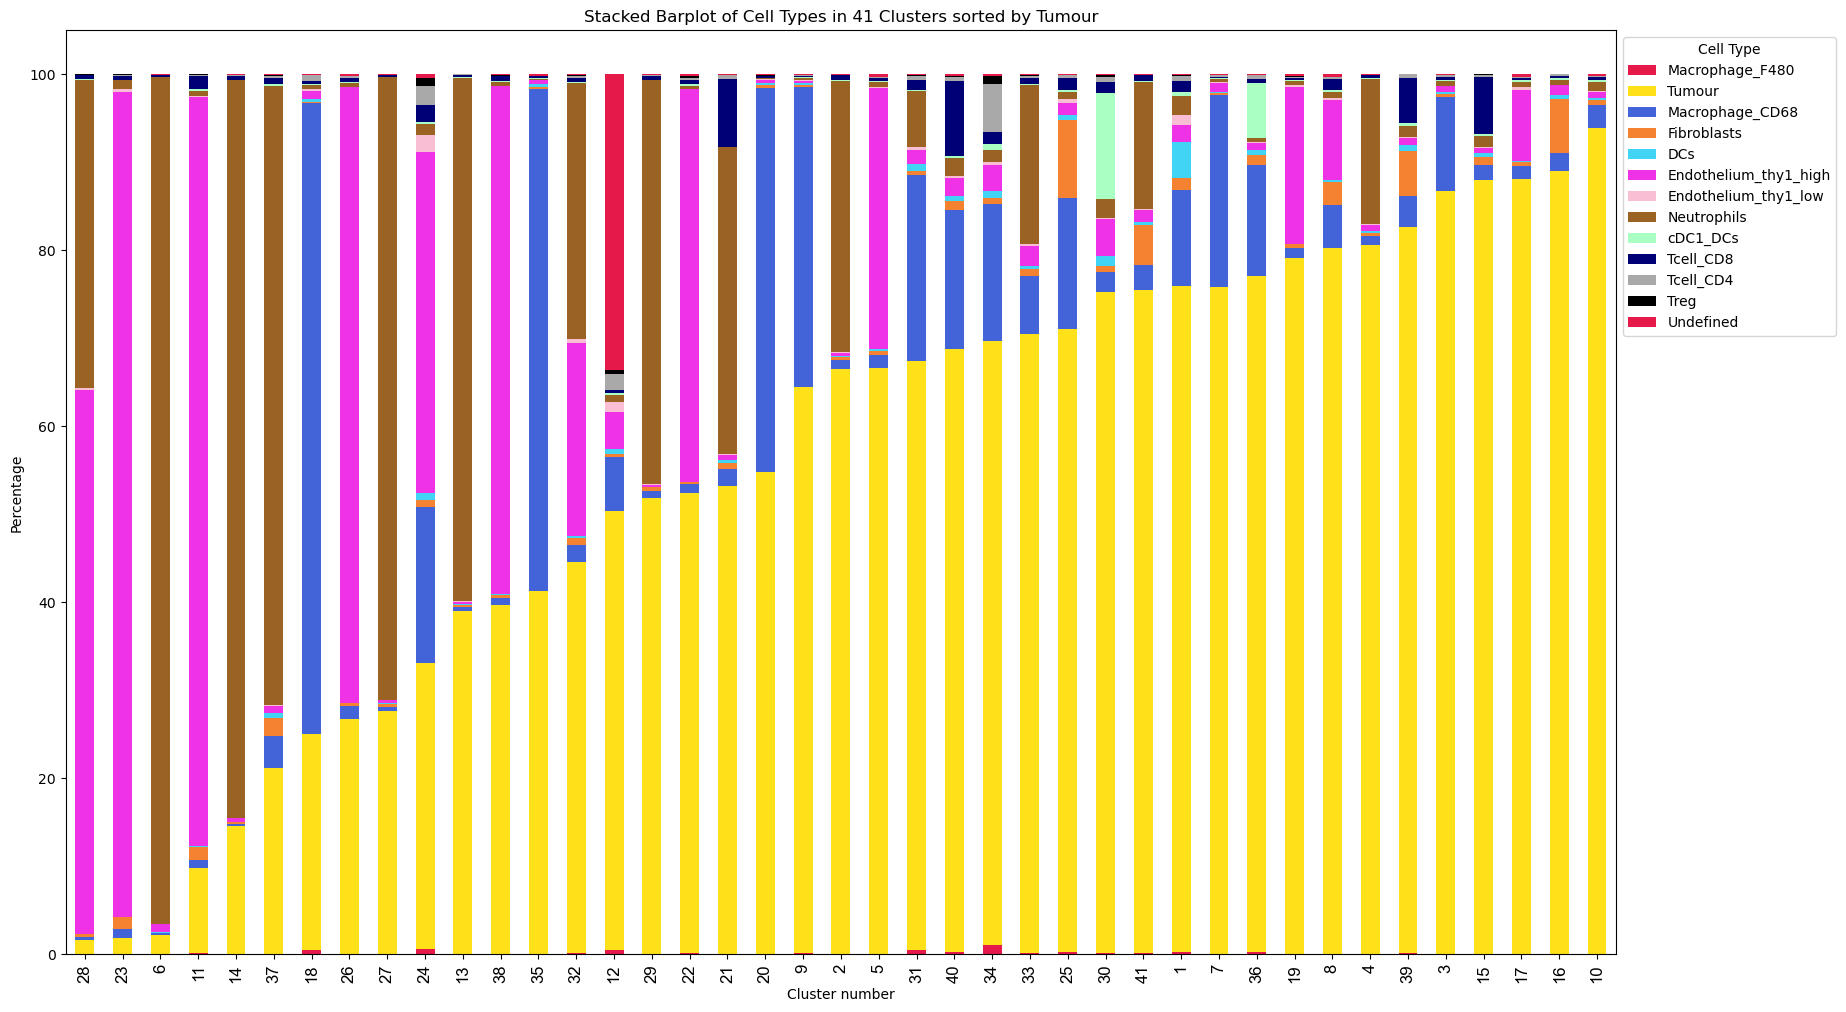

In [249]:
sort_celltype = 'Tumour'

# Grouping by 'cluster' and 'celltype' and getting counts
result = merged_df.groupby([f'clusterstotal_{num_clus}', 'source_cluster']).size().reset_index(name='Count')

# Pivot the table to get totals per cluster and cell type
result = result.pivot_table(index='source_cluster', columns=f'clusterstotal_{num_clus}', values='Count', fill_value=0)
# Sort by dendrogram
# result = result[clus_order]

# Add totals for each cluster
result.loc['Total_Cells'] = result.sum()

result_percentage = result.div(result.loc['Total_Cells'], axis=1) * 100

# Sort the columns based on the values in the selected row
sorted_columns = result_percentage.columns[result_percentage.loc[sort_celltype].argsort()]

# Reorder the DataFrame based on the sorted columns
result_percentage = result_percentage.iloc[:-1][sorted_columns]

# Reorder rows based on index
result_percentage = result_percentage.reindex(cts)


# Plotting
plt.figure(figsize=(20, 10))

ax = result_percentage.T.plot(kind='bar', stacked=True, figsize=(20, 12),width=0.5, color=colors)
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster number')
ax.set_title(f'Stacked Barplot of Cell Types in {num_clus} Clusters sorted by {sort_celltype}')
# plt.xticks(fontsize=3)
plt.xticks(fontsize=12, fontfamily='Arial', fontweight='normal')

# # Annotate total amount of cells above each bar
# for i, total in enumerate(result.loc['Total_Cells'][:-1]):  # Exclude the 'Total_Cells' row
#     ax.annotate(f'{total}', (i, 100), xytext=(0, 5), textcoords='offset points', ha='center', rotation=90, fontsize=3)

# Show plot
plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))

# plt.savefig(f'{data_path}plots/stacked_barplot_clusno_{num_clus}_sorted_{sort_celltype}.png', bbox_inches='tight', dpi=300)

plt.show()

In [250]:
# Annotate entire dataset with clusters after specific clustering k
# Set df
df_cl = average_neighbours28
num_clus = df_cl.iloc[:,-1].max()
key = df_cl[['cluster', f'clusterstotal_{num_clus}']]
merged_df = pd.merge(data, key, on='cluster', how='inner').drop(columns=['cluster', 'source_ID', 'Unique_ROI_ID', 'Group'])
merged_df_bu = pd.merge(data, key, on='cluster', how='inner')

merged_df_bu.rename(columns={f'cluster{num_clus}': f'clusterstotal_{num_clus}'}, inplace=True)
merged_df_bu.rename(columns={f'cluster': f'clusterstotal_306'}, inplace=True)

merged_df

,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,clusterstotal_28
0,Endothelium_thy1_high,0.0,0.250000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0,16
1,Neutrophils,0.0,0.285714,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.571429,0.0,0.0,16
2,Endothelium_thy1_high,0.0,0.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.666667,0.0,0.0,16
3,Tumour,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.666667,0.0,0.0,16
4,Tumour,0.0,0.200000,0.0,0.1,0.0,0.0,0.100000,0.0,0.0,0.0,0.600000,0.0,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704344,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,5
704345,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,5
704346,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,5
704347,Macrophage_CD68,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,5


<Figure size 2000x1000 with 0 Axes>

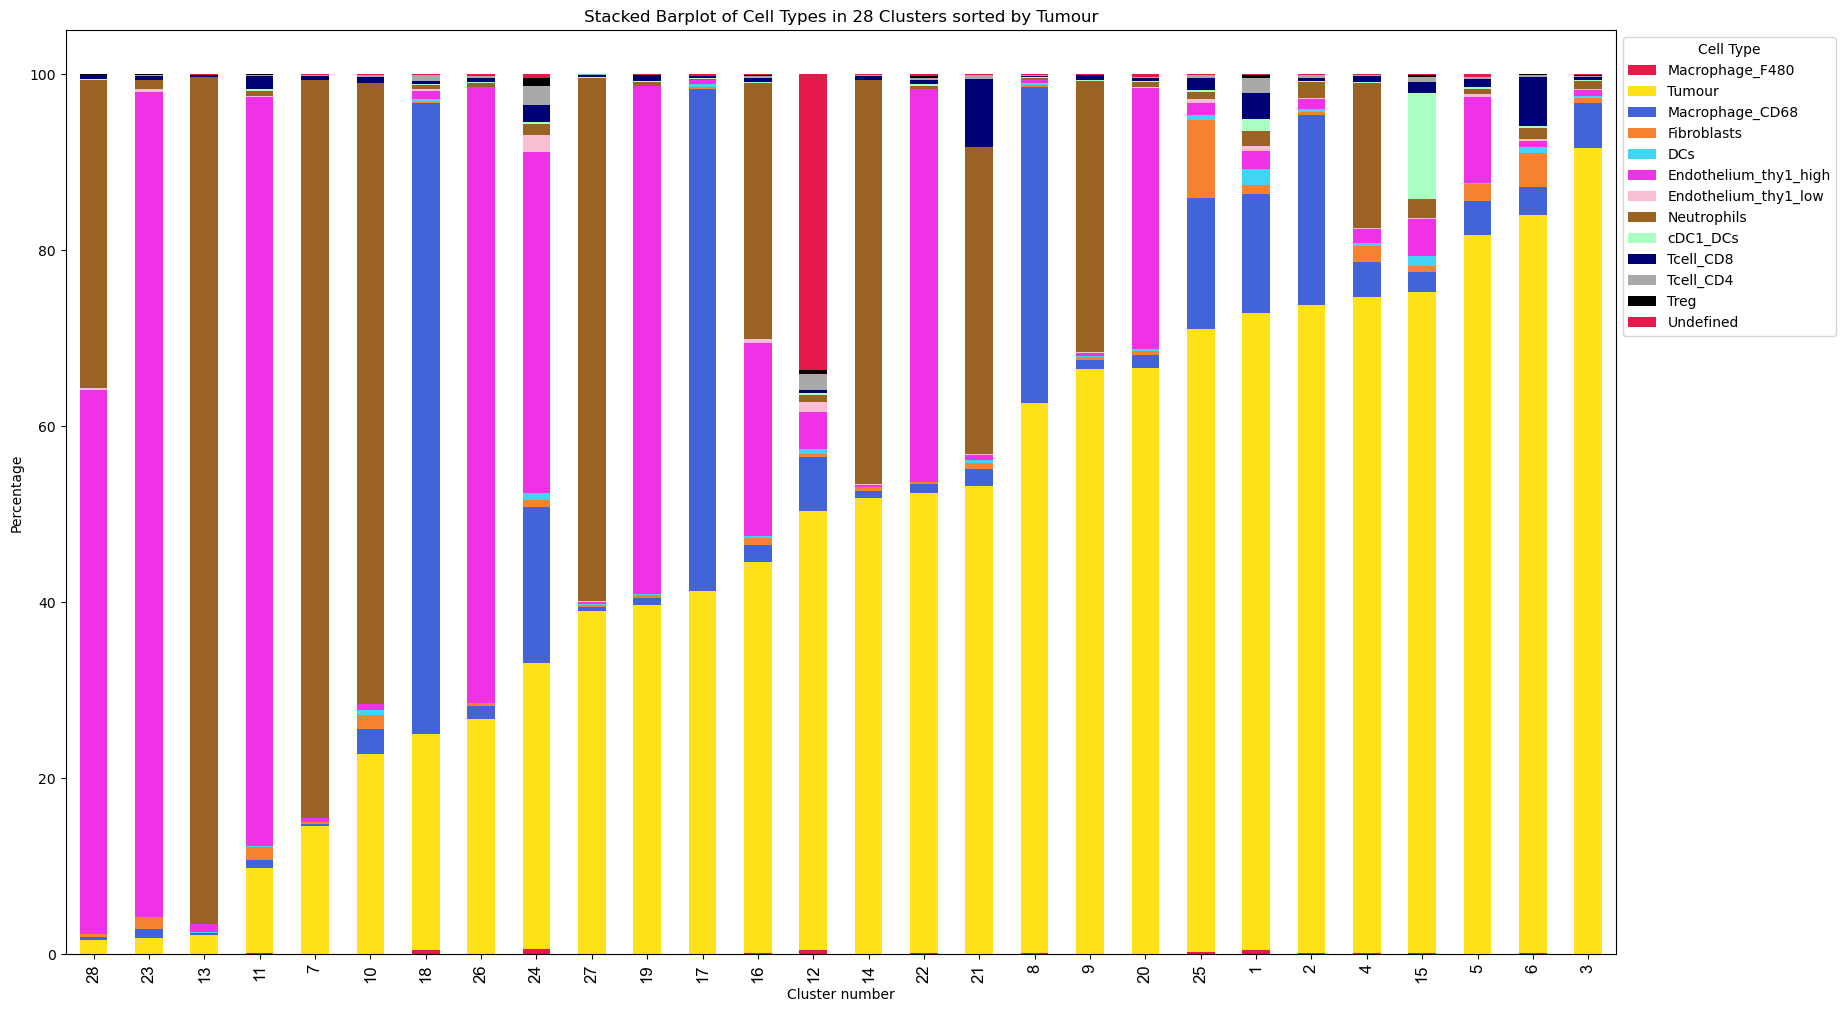

In [251]:
sort_celltype = 'Tumour'

# Grouping by 'cluster' and 'celltype' and getting counts
result = merged_df.groupby([f'clusterstotal_{num_clus}', 'source_cluster']).size().reset_index(name='Count')

# Pivot the table to get totals per cluster and cell type
result = result.pivot_table(index='source_cluster', columns=f'clusterstotal_{num_clus}', values='Count', fill_value=0)
# Sort by dendrogram
# result = result[clus_order]

# Add totals for each cell type and each cluster
# result['Total_Cell_Type'] = result.sum(axis=1)
result.loc['Total_Cells'] = result.sum()

result_percentage = result.div(result.loc['Total_Cells'], axis=1) * 100

# Sort the columns based on the values in the selected row
sorted_columns = result_percentage.columns[result_percentage.loc[sort_celltype].argsort()]

# Reorder the DataFrame based on the sorted columns
result_percentage = result_percentage.iloc[:-1][sorted_columns]

# Reorder rows based on index
result_percentage = result_percentage.reindex(cts)


# Plotting
plt.figure(figsize=(20, 10))

ax = result_percentage.T.plot(kind='bar', stacked=True, figsize=(20, 12),width=0.5, color=colors)
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster number')
ax.set_title(f'Stacked Barplot of Cell Types in {num_clus} Clusters sorted by {sort_celltype}')
# plt.xticks(fontsize=3)
plt.xticks(fontsize=12, fontfamily='Arial', fontweight='normal')

# # Annotate total amount of cells above each bar
# for i, total in enumerate(result.loc['Total_Cells'][:-1]):  # Exclude the 'Total_Cells' row
#     ax.annotate(f'{total}', (i, 100), xytext=(0, 5), textcoords='offset points', ha='center', rotation=90, fontsize=3)

# Show plot
plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))

# plt.savefig(f'{data_path}plots/stacked_barplot_clusno_{num_clus}_sorted_{sort_celltype}.png', bbox_inches='tight', dpi=300)

plt.show()

In [143]:
# 41 clusters, plot percentual contribution per group to each cluster
# Set df
df_cl = average_neighbours41
num_clus = df_cl.iloc[:,-1].max()
key = df_cl[['cluster', f'clusterstotal_{num_clus}']]
merged_df = pd.merge(data, key, on='cluster', how='inner').drop(columns=['cluster', 'source_ID', 'Unique_ROI_ID', 'Group'])
merged_df_bu = pd.merge(data, key, on='cluster', how='inner')

merged_df_bu.rename(columns={f'cluster{num_clus}': f'clusterstotal_{num_clus}'}, inplace=True)
merged_df_bu.rename(columns={f'cluster': f'clusterstotal_306'}, inplace=True)

merged_df_bu

,Unique_ROI_ID,source_ID,Group,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,Neutrophils,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,clusterstotal_306,clusterstotal_41
0,MOC2_WT_1B_2_17,1,WT,Endothelium_thy1_high,0.0,0.250000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0,1,32
1,MOC2_WT_1B_2_17,40,WT,Neutrophils,0.0,0.285714,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.571429,0.0,0.0,1,32
2,MOC2_WT_1B_2_17,63,WT,Endothelium_thy1_high,0.0,0.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.666667,0.0,0.0,1,32
3,MOC2_WT_1B_2_17,78,WT,Tumour,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.666667,0.0,0.0,1,32
4,MOC2_WT_1B_2_17,99,WT,Tumour,0.0,0.200000,0.0,0.1,0.0,0.0,0.100000,0.0,0.0,0.0,0.600000,0.0,0.0,1,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704344,MOC2_CCR2KO_NM_1_16,23786,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,306,17
704345,MOC2_CCR2KO_NM_1_16,23855,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,306,17
704346,MOC2_CCR2KO_NM_1_16,33446,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,306,17
704347,MOC2_CCR2KO_NM_1_16,46712,CCR2KO,Macrophage_CD68,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.913043,0.0,0.0,306,17


<Figure size 2000x1000 with 0 Axes>

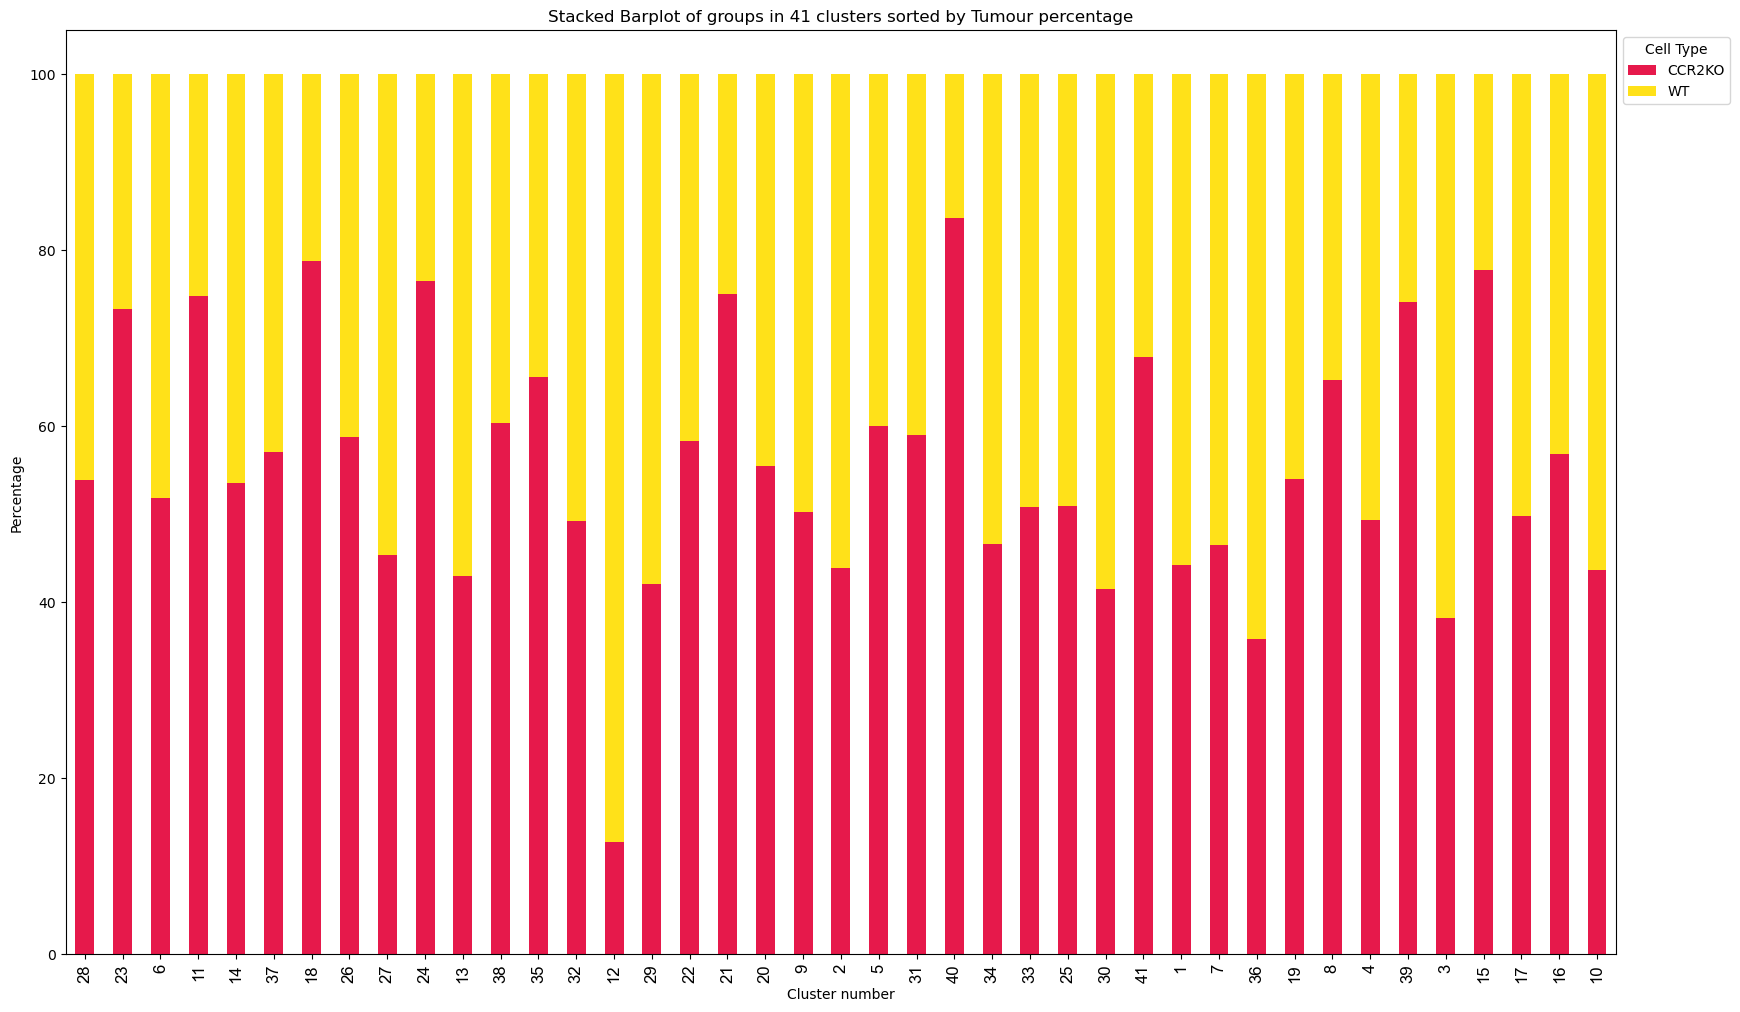

In [240]:
# stacked barplot per group
fracgroup = merged_df_bu[['Group', 'clusterstotal_41']].groupby(['Group', 'clusterstotal_41']).size().reset_index(name='Count_per_group')
fracgroup_vec = merged_df_bu[['clusterstotal_41']].groupby(['clusterstotal_41']).size().reset_index(name='Total_count')
fracgroup = pd.merge(fracgroup, fracgroup_vec, on='clusterstotal_41', how='inner')
fracgroup

sort_celltype = 'Tumour'

fracgroup['Percentage'] = 100*fracgroup['Count_per_group']/fracgroup['Total_count']
good_df = fracgroup[['Group', 'clusterstotal_41', 'Percentage']]
good_df


# Grouping by 'cluster' and getting counts

# Pivot the table to get totals per cluster and cell type
result = good_df.pivot_table(index='Group', columns=f'clusterstotal_{num_clus}', values='Percentage', fill_value=0)

# Reorder the DataFrame based on the sorted columns
result_percentage = result[sorted_columns]

# Plotting
plt.figure(figsize=(20, 10))

ax = result_percentage.T.plot(kind='bar', stacked=True, figsize=(20, 12),width=0.5, color=colors)
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster number')
ax.set_title(f'Stacked Barplot of groups in {num_clus} clusters sorted by {sort_celltype} percentage')
plt.xticks(fontsize=12, fontfamily='Arial', fontweight='normal')

# # Annotate total amount of cells above each bar
# for i, total in enumerate(result.loc['Total_Cells'][:-1]):  # Exclude the 'Total_Cells' row
#     ax.annotate(f'{total}', (i, 100), xytext=(0, 5), textcoords='offset points', ha='center', rotation=90, fontsize=3)

# Show plot
plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))

# plt.savefig(f'{data_path}plots/stacked_barplot_clusno_{num_clus}_sorted_{sort_celltype}.png', bbox_inches='tight', dpi=300)

plt.show()

In [239]:
# Save agglo cluster information
# num_clus = 29
key = average_neighbours28[['cluster', f'clusterstotal_28']]
df_clus = pd.merge(data, key, on='cluster', how='inner')
# num_clus = 40
key = average_neighbours41[['cluster', f'clusterstotal_41']]
df_clus = pd.merge(df_clus, key, on='cluster', how='inner')
# num_clus = 59
key = average_neighbours56[['cluster', f'clusterstotal_56']]
df_clus = pd.merge(df_clus, key, on='cluster', how='inner')


df_clus.to_csv(f"{data_path}/clustering/full_cd_clus_28_41_56.csv", index = False)
df_clus



,Unique_ROI_ID,source_ID,Group,source_cluster,DCs,Endothelium_thy1_high,Endothelium_thy1_low,Fibroblasts,Macrophage_CD68,Macrophage_F480,...,Tcell_CD4,Tcell_CD8,Treg,Tumour,Undefined,cDC1_DCs,cluster,clusterstotal_28,clusterstotal_41,clusterstotal_56
0,MOC2_WT_1B_2_17,1,WT,Endothelium_thy1_high,0.0,0.250000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.500000,0.0,0.0,1,16,32,32
1,MOC2_WT_1B_2_17,40,WT,Neutrophils,0.0,0.285714,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.571429,0.0,0.0,1,16,32,32
2,MOC2_WT_1B_2_17,63,WT,Endothelium_thy1_high,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.666667,0.0,0.0,1,16,32,32
3,MOC2_WT_1B_2_17,78,WT,Tumour,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.666667,0.0,0.0,1,16,32,32
4,MOC2_WT_1B_2_17,99,WT,Tumour,0.0,0.200000,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.600000,0.0,0.0,1,16,32,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704344,MOC2_CCR2KO_NM_1_16,23786,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.913043,0.0,0.0,306,5,17,8
704345,MOC2_CCR2KO_NM_1_16,23855,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.913043,0.0,0.0,306,5,17,8
704346,MOC2_CCR2KO_NM_1_16,33446,CCR2KO,Tumour,0.0,0.086957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.913043,0.0,0.0,306,5,17,8
704347,MOC2_CCR2KO_NM_1_16,46712,CCR2KO,Macrophage_CD68,0.0,0.086957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.913043,0.0,0.0,306,5,17,8


In [254]:
# # Annotate entire dataset with clusters after specific clustering k
# # Set df
# df_cl = average_neighbours41
# num_clus = df_cl.iloc[:,-1].max()
# key = df_cl[['cluster', f'clusterstotal_{num_clus}']]
# merged_df = pd.merge(data, key, on='cluster', how='inner').drop(columns=['cluster', 'source_ID', 'Unique_ROI_ID'])
# merged_df_bu = pd.merge(data, key, on='cluster', how='inner')

# merged_df_bu.rename(columns={f'cluster{num_clus}': f'clusterstotal_{num_clus}'}, inplace=True)
# merged_df_bu.rename(columns={f'cluster': f'clusterstotal_306'}, inplace=True)

# merged_df_KO = merged_df[merged_df['Group']== 'CCR2KO'].drop(columns=['Group'])
# merged_df_WT = merged_df[merged_df['Group']== 'WT'].drop(columns=['Group'])



# sort_celltype = 'Tumour'

# # Grouping by 'cluster' and 'celltype' and getting counts
# result = merged_df_KO.groupby([f'clusterstotal_{num_clus}', 'source_cluster']).size().reset_index(name='Count')

# # Pivot the table to get totals per cluster and cell type
# result = result.pivot_table(index='source_cluster', columns=f'clusterstotal_{num_clus}', values='Count', fill_value=0)
# # Sort by dendrogram
# # result = result[clus_order]

# # Add totals for each cell type and each cluster
# result['Total_Cell_Type'] = result.sum(axis=1)
# result.loc['Total_Cells'] = result.sum()

# result_percentage = result.iloc[:,:-1].div(result.loc['Total_Cells'], axis=1) * 100

# # Sort the columns based on the values in the selected row
# sorted_columns = result_percentage.columns[result_percentage.loc[sort_celltype].argsort()]

# # Reorder the DataFrame based on the sorted columns
# result_percentage = result_percentage[sorted_columns]


# # Plotting
# plt.figure(figsize=(20, 10))

# ax = result_percentage.iloc[:-1,:-1].T.plot(kind='bar', stacked=True, figsize=(20, 12),width=0.5, color=colors)
# ax.set_ylabel('Percentage')
# ax.set_xlabel('Cluster number')
# ax.set_title(f'Stacked Barplot of Cell Types in {num_clus} Clusters sorted by {sort_celltype} percentage for CCR2-KO')
# # plt.xticks(fontsize=3)
# plt.xticks(fontsize=12, fontfamily='Arial', fontweight='normal')

# # # Annotate total amount of cells above each bar
# # for i, total in enumerate(result.loc['Total_Cells'][:-1]):  # Exclude the 'Total_Cells' row
# #     ax.annotate(f'{total}', (i, 100), xytext=(0, 5), textcoords='offset points', ha='center', rotation=90, fontsize=3)

# # Show plot
# plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))

# # plt.savefig(f'{data_path}plots/stacked_barplot_clusno_{num_clus}_sorted_{sort_celltype}.png', bbox_inches='tight', dpi=300)

# plt.show()